## RQ4

What is the most common way of payments? Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.

In [81]:
''' imports '''
import pandas as pd
import numpy as np
from loader import Loader
import matplotlib.pyplot as plt
%matplotlib notebook

''' data paths '''
data = {
    'jan': {
        'path': 'data/yellow_tripdata_2018-01.csv',
        'start': '2018-01-01',
        'end': '2018-01-31'
    },
    'feb': {
        'path': 'data/yellow_tripdata_2018-02.csv',
        'start': '2018-02-01',
        'end': '2018-02-28'
    },
    'mar': {
        'path': 'data/yellow_tripdata_2018-03.csv',
        'start': '2018-03-01',
        'end': '2018-03-31'
    },
    'apr': {
        'path': 'data/yellow_tripdata_2018-04.csv',
        'start': '2018-04-01',
        'end': '2018-04-30'
    },
    'may': {
        'path': 'data/yellow_tripdata_2018-05.csv',
        'start': '2018-05-01',
        'end': '2018-05-31'
    },
    'jun': {
        'path': 'data/yellow_tripdata_2018-06.csv',
        'start': '2018-06-01',
        'end': '2018-06-30'
    }
}
locations = 'data/taxi_zone_lookup.csv'

# make it dynamic
# MONTH = data['jan']
MONTHS = [(m, data[m]['path']) for m in data.keys()]

In [82]:
# read data for each month
loader = Loader(csv=MONTHS, chunksize=100000, nrows=100000)

# preparing locations to be merged on-the-fly when iterating
loader.merge(csv=locations, usecols=['LocationID', 'Borough'], on=('PULocationID', 'LocationID'), direction='left', drop_on_columns=True)

# get data generator
data_iterator = loader.iterate(usecols=['PULocationID', 'payment_type'])

In [83]:
''' working with each borough '''
# declaring two counters to enhance verbosity
tot_rows = 0
processed_rows = 0

# count will be stored here
# and incremented chunk by chunk
dg_bkp = None

# iterate over chunks
for month, d in data_iterator:
    
    # info
    tot_rows += len(d.index)
    
    # drop any row with missing values
    d = d.dropna()
    
    # group by
    dg = d.groupby(['payment_type', 'Borough']).Borough.agg('count').to_frame('count')
    
    # info
    processed_rows += len(d.index)
    
    # concat and save data
    dg_bkp = pd.concat([dg, dg_bkp]) if dg_bkp is not None else dg
    
    # re-group and sum() to keep less stuff in memory
    dg_bkp = dg_bkp.groupby(['payment_type', 'Borough']).sum()
    
print(str(processed_rows) + ' over ' + str(tot_rows) + ' rows have been processed')

600000 over 600000 rows have been processed


In [84]:
# defining payment methods
methods = [('Credit Card', 1),
         ('Cash', 2),
         ('No chard', 3),
         ('Dispute', 4),
         ('Unknown', 5),
         ('Voided trip', 6)
        ]
labels = ['Method', 'code']
p = pd.DataFrame.from_records(methods, columns=labels)
p.head()

,Method,code
0,Credit Card,1
1,Cash,2
2,No chard,3
3,Dispute,4
4,Unknown,5


In [ ]:
# expanding Borough index to each line
dg_bkp.reset_index(level=dg_bkp.index.names, inplace=True)

print(dg_bkp.head())
print(len(dg_bkp.index))

In [86]:
dg_bkp_p = dg_bkp.merge(p, left_on='payment_type', right_on='code', how='left')
dg_bkp_p = dg_bkp_p.fillna(0)
dg_bkp_p = dg_bkp_p.drop(['payment_type', 'code'], axis=1)

print(dg_bkp_p)
print(len(dg_bkp_p.index))

          Borough   count       Method
0           Bronx     498  Credit Card
1        Brooklyn    7372  Credit Card
2             EWR      27  Credit Card
3       Manhattan  372696  Credit Card
4          Queens   19484  Credit Card
5   Staten Island       5  Credit Card
6         Unknown    6626  Credit Card
7           Bronx     702         Cash
8        Brooklyn    4182         Cash
9             EWR       7         Cash
10      Manhattan  168305         Cash
11         Queens   12207         Cash
12  Staten Island       3         Cash
13        Unknown    3304         Cash
14          Bronx      33     No chard
15       Brooklyn     161     No chard
16            EWR       1     No chard
17      Manhattan    2841     No chard
18         Queens     414     No chard
19        Unknown     141     No chard
20          Bronx      10      Dispute
21       Brooklyn      39      Dispute
22      Manhattan     803      Dispute
23         Queens     102      Dispute
24        Unknown      37

<IPython.core.display.Javascript object>


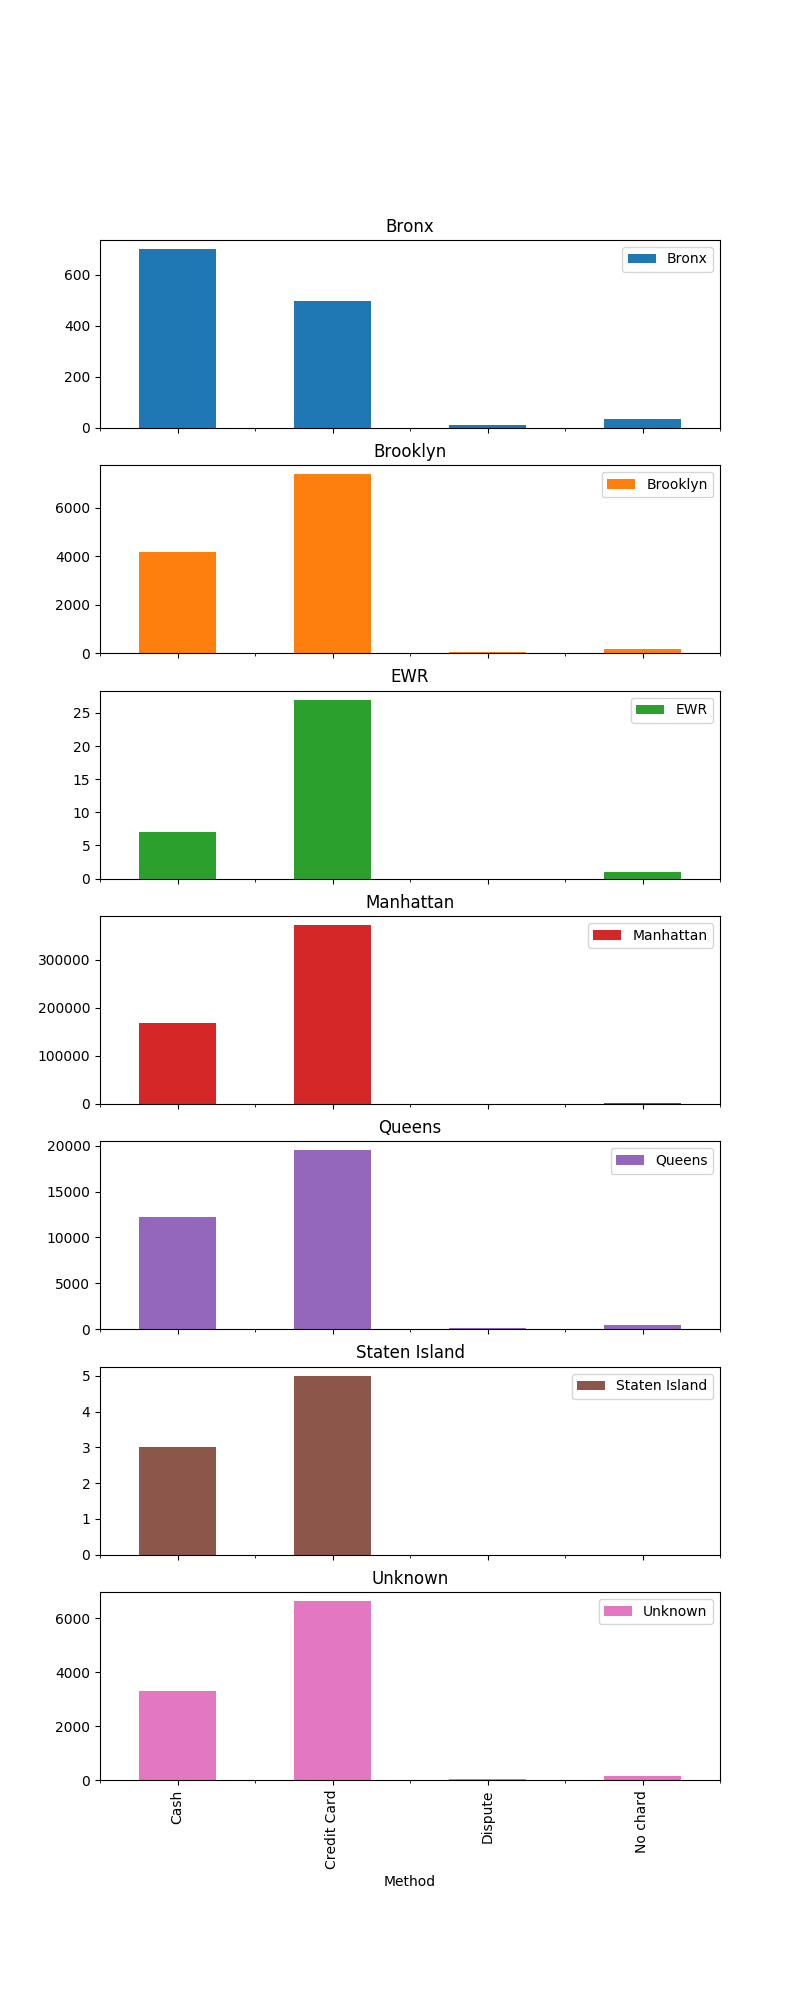

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3671aaf28>,
      dtype=object)

In [122]:
test = dg_bkp_p.groupby(['Method', 'Borough'])['count'].sum()
test.head()

test.unstack().plot(kind='bar', subplots=True, figsize=(8,20))